In [1]:
import os
import torch
import torchvision
import tarfile
import numpy as np
from torchvision.datasets.utils import download_url

In [2]:
# Download file from https://files.fast.ai/data/examples/
with tarfile.open('../input/cifar10/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [4]:
data_dir = 'data/cifar10/'
dataset = ImageFolder(data_dir+'train', transform=ToTensor())

In [5]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

In [6]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('label: ', dataset.classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1, 2, 0))

label:  airplane (0)


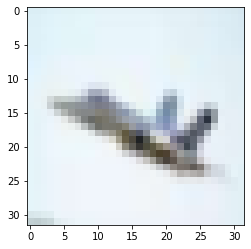

In [8]:
show_example(*dataset[0])

label:  airplane (0)


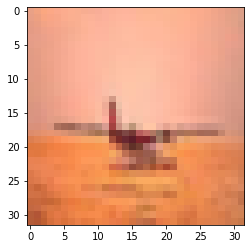

In [9]:
show_example(*dataset[1099])

In [10]:
def split_indicies(n, val_pct, seed=99):
    # Determine size of validation set
    n_val = int(val_pct * n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indicies for validation set
    return idxs[n_val:], idxs[:n_val]

In [11]:
val_pct = 0.2
random_seed = 42

train_indicies, val_indicies = split_indicies(len(dataset), val_pct, seed=random_seed)
print(len(train_indicies), len(val_indicies))

40000 10000


In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [13]:
batch_size=100

train_sampler = SubsetRandomSampler(train_indicies)
train_dl = DataLoader(dataset,
                      batch_size=batch_size,
                      sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indicies)
val_dl = DataLoader(dataset,
                    batch_size=batch_size,
                    sampler=val_sampler)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1, 2, 0))
        break

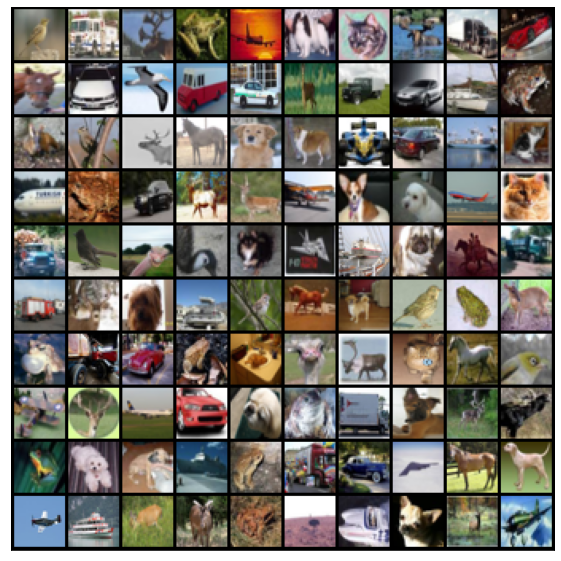

In [15]:
show_batch(train_dl)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
# ?nn.Conv2d

In [18]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [19]:
for images, labels in train_dl:
    print("images shape", images.shape)
    out = simple_model(images)
    print('output shape', out.shape)
    break

images shape torch.Size([100, 3, 32, 32])
output shape torch.Size([100, 8, 16, 16])


In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: bs x 16 x 16 x 16
            
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: bs x 16 x 8 x 8
            
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: bs x 16 x 4 x 4
            
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: bs x 16 x 2 x 2
            
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: bs x 16 x 1 x 1
            
            nn.Flatten(), # output bs x 16
            nn.Linear(16, 10) # Output bs x 10
        )
    
    def forward(self, xb):
        return self.network(xb)

In [22]:
model = Cifar10CnnModel()

In [23]:
model.network[3].weight.shape

torch.Size([16, 16, 3, 3])

In [24]:
for images, labels in train_dl:
    print('images shape', images.shape)
    out = model(images)
    print("out shape", out.shape)
    print('out[0]:', F.softmax(out[0], dim=0))
    print(torch.max(F.softmax(out[0], dim=0)))
    break

images shape torch.Size([100, 3, 32, 32])
out shape torch.Size([100, 10])
out[0]: tensor([0.0871, 0.0811, 0.1149, 0.0904, 0.1013, 0.1146, 0.0848, 0.1060, 0.1137,
        0.1060], grad_fn=<SoftmaxBackward>)
tensor(0.1149, grad_fn=<MaxBackward1>)


In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, valid_loader, opt_func=torch.optim.SGD):
    history = []
    train_losses = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation Phase
        result = evaluate(model, valid_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
model = to_device(Cifar10CnnModel(), device)

In [36]:
evaluate(model, valid_dl)

{'val_loss': 2.316864013671875, 'val_acc': 0.09549999237060547}

In [37]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [38]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch [0], train_loss: 2.0114, val_loss: 1.7652, val_acc: 0.3426
Epoch [1], train_loss: 1.8462, val_loss: 1.5879, val_acc: 0.4109
Epoch [2], train_loss: 1.7558, val_loss: 1.5229, val_acc: 0.4404
Epoch [3], train_loss: 1.6960, val_loss: 1.4788, val_acc: 0.4596
Epoch [4], train_loss: 1.6505, val_loss: 1.4701, val_acc: 0.4661
Epoch [5], train_loss: 1.6141, val_loss: 1.4402, val_acc: 0.4740
Epoch [6], train_loss: 1.5820, val_loss: 1.3823, val_acc: 0.4940
Epoch [7], train_loss: 1.5532, val_loss: 1.3308, val_acc: 0.5194
Epoch [8], train_loss: 1.5273, val_loss: 1.3324, val_acc: 0.5162
Epoch [9], train_loss: 1.5034, val_loss: 1.2775, val_acc: 0.5404
Epoch [10], train_loss: 1.4814, val_loss: 1.2930, val_acc: 0.5366
Epoch [11], train_loss: 1.4614, val_loss: 1.3074, val_acc: 0.5307
Epoch [12], train_loss: 1.4429, val_loss: 1.2205, val_acc: 0.5662
Epoch [13], train_loss: 1.4255, val_loss: 1.2073, val_acc: 0.5681
Epoch [14], train_loss: 1.4093, val_loss: 1.1953, val_acc: 0.5773
Epoch [15], train_lo

In [39]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

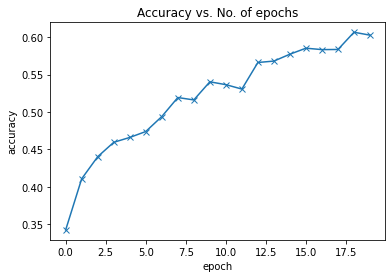

In [40]:
plot_accuracies(history)

In [41]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

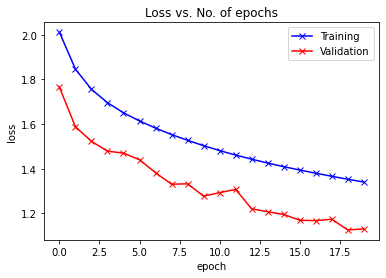

In [42]:
plot_losses(history)